In [2]:
"""Import modules required to run the Jupyter notebook."""
from __future__ import annotations

# Configure logging
import logging
import warnings
if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

# Downloading data and files
import shutil
from pathlib import Path
from zipfile import ZipFile

# Data processing and visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import PIL
import contextlib
import io
from sklearn.metrics import accuracy_score, confusion_matrix

# TIAToolbox for WSI loading and processing
from tiatoolbox import logger
from tiatoolbox.models.architecture import vanilla
from tiatoolbox.models.engine.patch_predictor import (
    IOPatchPredictorConfig,
    PatchPredictor,
)
from tiatoolbox.utils.misc import download_data, grab_files_from_dir
from tiatoolbox.utils.visualization import overlay_prediction_mask
from tiatoolbox.wsicore.wsireader import WSIReader

# Torch-related
import torch
from torchvision import transforms

# Configure plotting
mpl.rcParams["figure.dpi"] = 160  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode

# If you are not using GPU, change ON_GPU to False
ON_GPU = True

# Function to suppress console output for overly verbose code blocks
def suppress_console_output():
    return contextlib.redirect_stderr(io.StringIO())

In [3]:
warnings.filterwarnings("ignore")
global_save_dir = Path("./tmp/")


def rmdir(dir_path: str | Path) -> None:
    """Helper function to delete directory."""
    if Path(dir_path).is_dir():
        shutil.rmtree(dir_path)
        logger.info("Removing directory %s", dir_path)


rmdir(global_save_dir)  # remove  directory if it exists from previous runs
global_save_dir.mkdir()
logger.info("Creating new directory %s", global_save_dir)

|2024-10-28|15:10:04.919| [INFO] Removing directory tmp
|2024-10-28|15:10:04.920| [INFO] Creating new directory tmp


In [4]:
wsi_path = global_save_dir / "sample_wsi.svs"
patches_path = global_save_dir / "kather100k-validation-sample.zip"
weights_path = global_save_dir / "resnet18-kather100k.pth"

logger.info("Download has started. Please wait...")

# Downloading and unzip a sample whole-slide image
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs",
    wsi_path,
)

# Download and unzip a sample of the validation set used to train the Kather 100K dataset
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip",
    patches_path,
)
with ZipFile(patches_path, "r") as zipfile:
    zipfile.extractall(path=global_save_dir)

# Download pretrained model weights for WSI classification using ResNet18 architecture
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/models/pc/resnet18-kather100k.pth",
    weights_path,
)

print("Download Complete!")

|2024-10-28|15:10:04.926| [INFO] Download has started. Please wait...
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs
Save to tmp/sample_wsi.svs
Download from https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip
Save to tmp/kather100k-validation-sample.zip
Download from https://tiatoolbox.dcs.warwick.ac.uk/models/pc/resnet18-kather100k.pth
Save to tmp/resnet18-kather100k.pth
Download Complete!


|2024-10-28|15:10:44.579| [INFO] Class ID: 0 -- Class Name: BACK -- Number of images: 211
|2024-10-28|15:10:44.579| [INFO] Class ID: 1 -- Class Name: NORM -- Number of images: 176
|2024-10-28|15:10:44.580| [INFO] Class ID: 2 -- Class Name: DEB -- Number of images: 230
|2024-10-28|15:10:44.580| [INFO] Class ID: 3 -- Class Name: TUM -- Number of images: 286
|2024-10-28|15:10:44.581| [INFO] Class ID: 4 -- Class Name: ADI -- Number of images: 208
|2024-10-28|15:10:44.581| [INFO] Class ID: 5 -- Class Name: MUC -- Number of images: 178
|2024-10-28|15:10:44.581| [INFO] Class ID: 6 -- Class Name: MUS -- Number of images: 270
|2024-10-28|15:10:44.582| [INFO] Class ID: 7 -- Class Name: STR -- Number of images: 209
|2024-10-28|15:10:44.582| [INFO] Class ID: 8 -- Class Name: LYM -- Number of images: 232
|2024-10-28|15:10:44.582| [INFO] Total number of patches: 2000


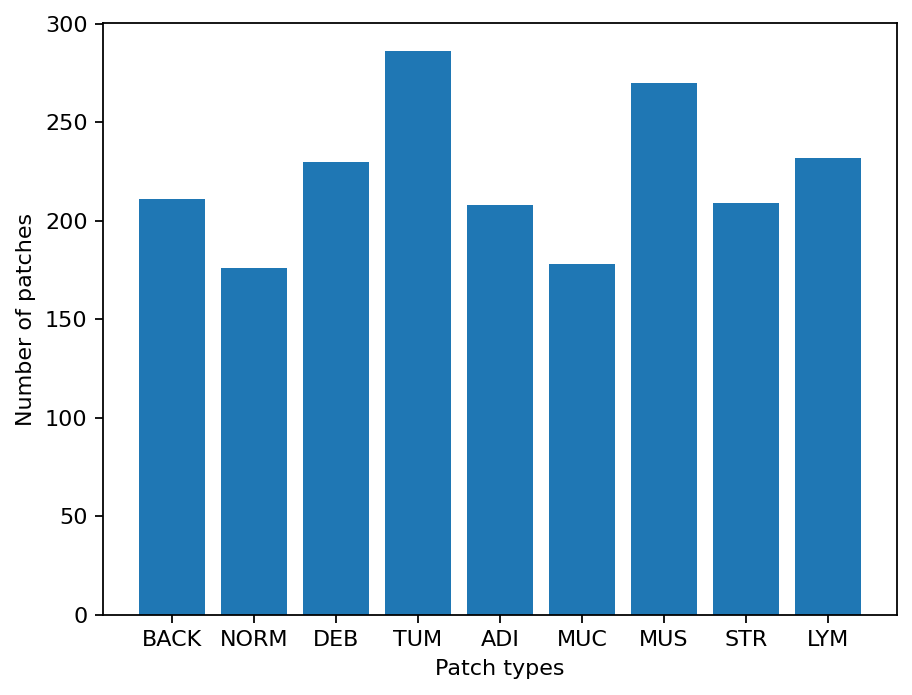

In [5]:
# Read the patch data and create a list of patches and a list of corresponding labels
dataset_path = global_save_dir / "kather100k-validation-sample"

# Set the path to the dataset
image_ext = ".tif"  # file extension of each image

# Obtain the mapping between the label ID and the class name
label_dict = {
    "BACK": 0, # Background (empty glass region)
    "NORM": 1, # Normal colon mucosa
    "DEB": 2,  # Debris
    "TUM": 3,  # Colorectal adenocarcinoma epithelium
    "ADI": 4,  # Adipose
    "MUC": 5,  # Mucus
    "MUS": 6,  # Smooth muscle
    "STR": 7,  # Cancer-associated stroma
    "LYM": 8,  # Lymphocytes
}

class_names = list(label_dict.keys())
class_labels = list(label_dict.values())

# Generate a list of patches and generate the label from the filename
patch_list = []
label_list = []
for class_name, label in label_dict.items():
    dataset_class_path = dataset_path / class_name
    patch_list_single_class = grab_files_from_dir(
        dataset_class_path,
        file_types="*" + image_ext,
    )
    patch_list.extend(patch_list_single_class)
    label_list.extend([label] * len(patch_list_single_class))

# Show some dataset statistics
plt.bar(class_names, [label_list.count(label) for label in class_labels])
plt.xlabel("Patch types")
plt.ylabel("Number of patches")

# Count the number of examples per class
for class_name, label in label_dict.items():
    logger.info(
        "Class ID: %d -- Class Name: %s -- Number of images: %d",
        label,
        class_name,
        label_list.count(label),
    )

# Overall dataset statistics
logger.info("Total number of patches: %d", (len(patch_list)))

In [6]:
# Importing a pretrained PyTorch model from TIAToolbox
predictor = PatchPredictor(pretrained_model='resnet18-kather100k', batch_size=32)

# Users can load any PyTorch model architecture instead using the following script
model = vanilla.CNNModel(backbone="resnet18", num_classes=9) # Importing model from torchvision.models.resnet18
model.load_state_dict(torch.load(weights_path, map_location="cpu", weights_only=True), strict=True)
def preproc_func(img):
    img = PIL.Image.fromarray(img)
    img = transforms.ToTensor()(img)
    return img.permute(1, 2, 0)
model.preproc_func = preproc_func
predictor = PatchPredictor(model=model, batch_size=32)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/deto/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.8MB/s]


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/pc/resnet18-kather100k.pth
Save to /home/deto/.tiatoolbox/models/resnet18-kather100k.pth


In [7]:
with suppress_console_output():
    output = predictor.predict(imgs=patch_list, mode="patch", on_gpu=ON_GPU)

acc = accuracy_score(label_list, output["predictions"])
logger.info("Classification accuracy: %f", acc)

# Creating and visualizing the confusion matrix for patch classification results
conf = confusion_matrix(label_list, output["predictions"], normalize="true")
df_cm = pd.DataFrame(conf, index=class_names, columns=class_names)
df_cm

|2024-10-28|15:14:20.767| [INFO] Classification accuracy: 0.993000


,BACK,NORM,DEB,TUM,ADI,MUC,MUS,STR,LYM
BACK,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
NORM,0.000000,0.988636,0.000000,0.011364,0.000000,0.000000,0.000000,0.000000,0.00000
DEB,0.000000,0.000000,0.991304,0.000000,0.000000,0.000000,0.000000,0.008696,0.00000
TUM,0.000000,0.000000,0.000000,0.996503,0.000000,0.003497,0.000000,0.000000,0.00000
ADI,0.004808,0.000000,0.000000,0.000000,0.990385,0.000000,0.004808,0.000000,0.00000
MUC,0.000000,0.000000,0.000000,0.000000,0.000000,0.988764,0.000000,0.011236,0.00000
MUS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996296,0.003704,0.00000
STR,0.000000,0.000000,0.004785,0.000000,0.000000,0.004785,0.004785,0.985646,0.00000
LYM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004310,0.99569


In [8]:
wsi_ioconfig = IOPatchPredictorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 0.5}],
    patch_input_shape=[224, 224],
    stride_shape=[224, 224],
)

In [9]:
with suppress_console_output():
    wsi_output = predictor.predict(
        imgs=[wsi_path],
        masks=None,
        mode="wsi",
        merge_predictions=False,
        ioconfig=wsi_ioconfig,
        return_probabilities=True,
        save_dir=global_save_dir / "wsi_predictions",
        on_gpu=ON_GPU,
    )

|2024-10-28|15:32:23.639| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.


(-0.5, 6039.5, 4703.5, -0.5)

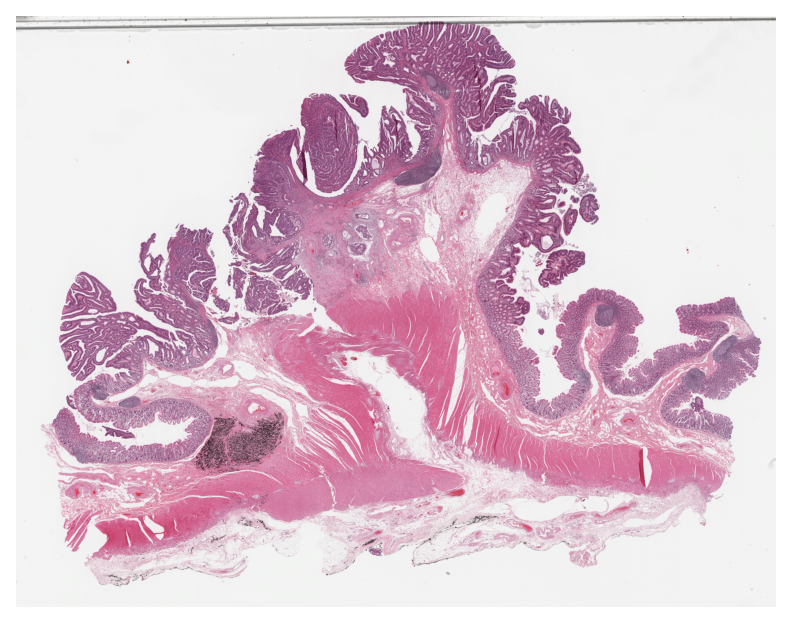

In [15]:
overview_resolution = (
    4  # the resolution in which we desire to merge and visualize the patch predictions
)
# the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"
overview_unit = "mpp"
wsi = WSIReader.open(wsi_path)
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)
plt.figure(), plt.imshow(wsi_overview)
plt.axis("off")

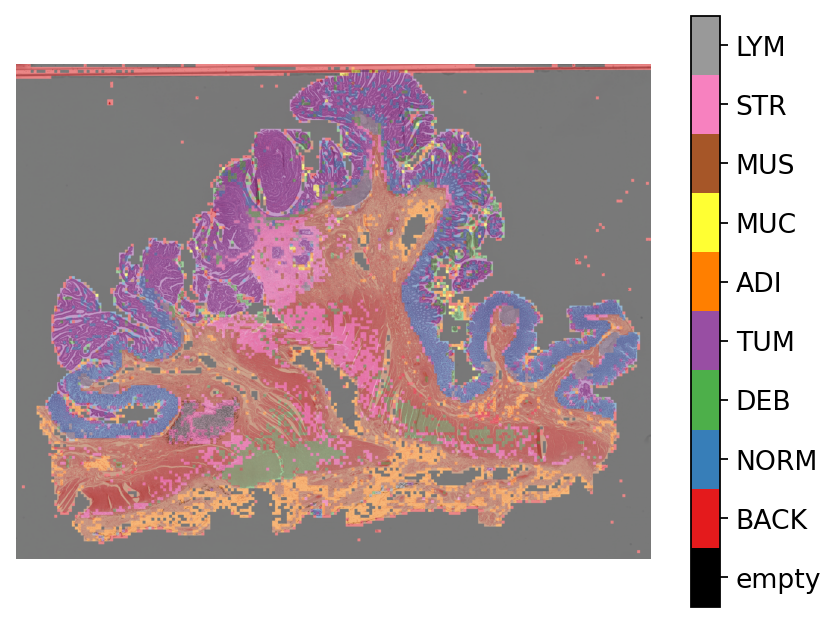

In [16]:
# Visualization of whole-slide image patch-level prediction
# first set up a label to color mapping
label_color_dict = {}
label_color_dict[0] = ("empty", (0, 0, 0))
colors = cm.get_cmap("Set1").colors
for class_name, label in label_dict.items():
    label_color_dict[label + 1] = (class_name, 255 * np.array(colors[label]))

pred_map = predictor.merge_predictions(
    wsi_path,
    wsi_output[0],
    resolution=overview_resolution,
    units=overview_unit,
)
overlay = overlay_prediction_mask(
    wsi_overview,
    pred_map,
    alpha=0.5,
    label_info=label_color_dict,
    return_ax=True,
)
plt.show()